In [17]:
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
data = pd.read_csv('../data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [20]:
data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [22]:
data.isna().mean()

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

Первый способ ANOVA

In [23]:
import scipy.stats as sts

In [24]:
bmi = data[['bmi', 'region']]
groups = bmi.groupby('region').groups
sts.f_oneway(*[bmi.iloc[groups[key], :-1] for key in groups.keys()])

F_onewayResult(statistic=array([39.4950572]), pvalue=array([1.88183891e-24]))

pvalue гораздо ниже 0.05 -> регион значительно влияет на bmi

Второй способ ANOVA

In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [26]:
model = ols('bmi ~ region', data=bmi).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
anova_result

,sum_sq,df,F,PR(>F)
region,4055.880631,3.0,39.495057,1.881839e-24
Residual,45664.319755,1334.0,NaN,NaN


Попарные тесты t-Критерия Стьюдента

In [27]:
import itertools
ttest = dict()
print(0.05 / 6)
for pair in itertools.combinations(groups, 2):
    ttest[pair] = sts.ttest_ind(*(bmi.iloc[groups[t], :-1] for t in pair))[1][0]
ttest

0.008333333333333333


{('northeast', 'northwest'): 0.951929170821864,
 ('northeast', 'southeast'): 1.186014937424813e-17,
 ('northeast', 'southwest'): 0.0019086161671573072,
 ('northwest', 'southeast'): 2.643571405230106e-19,
 ('northwest', 'southwest'): 0.001076958496307695,
 ('southeast', 'southwest'): 5.4374009639680636e-09}

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.0263,0.9999,-1.1552,1.2078,False
northeast,southeast,4.1825,-0.0,3.033,5.332,True
northeast,southwest,1.4231,0.0107,0.2416,2.6046,True
northwest,southeast,4.1562,-0.0,3.0077,5.3047,True
northwest,southwest,1.3968,0.0127,0.2162,2.5774,True
southeast,southwest,-2.7594,0.0,-3.9079,-1.6108,True


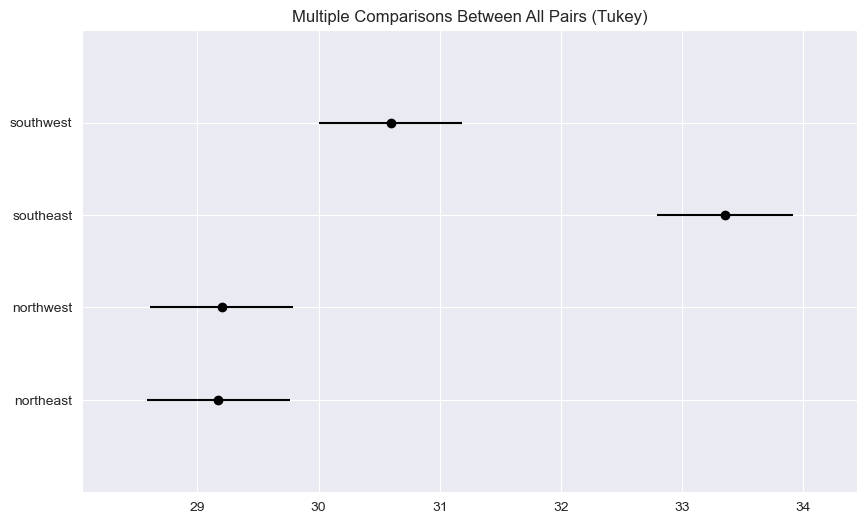

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=bmi['bmi'], groups=bmi['region'], alpha=0.05)
tukey.plot_simultaneous()
# plt.vlines(x=bmi['bmi'].mean(), ymin=-0.5, ymax=3.5)
tukey.summary()

Двухфакторный анализ

In [29]:
bmi = bmi.assign(sex=data['sex'])
bmi

,bmi,region,sex
0,27.900,southwest,female
1,33.770,southeast,male
2,33.000,southeast,male
3,22.705,northwest,male
4,28.880,northwest,male
...,...,...,...
1333,30.970,northwest,male
1334,31.920,northeast,female
1335,36.850,southeast,female
1336,25.800,southwest,female


In [30]:
model = ols('bmi ~ region + sex + region:sex', data=bmi).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
region,4034.975135,3.0,39.398134,2.163195e-24
sex,86.007035,1.0,2.519359,1.126940e-01
region:sex,174.157808,3.0,1.700504,1.650655e-01
Residual,45404.154911,1330.0,NaN,NaN


pvalue региона гораздо меньше 0.05 -> значительно влияет на bmi
пол больше 0.05 -> не влияет на bmi
пол+регион больше 0.05 -> значительного эффекта взаимодействия между признаками нет

group1,group2,meandiff,p-adj,lower,upper,reject
northeast / female,northeast / male,-0.2998,0.9998,-2.2706,1.6711,False
northeast / female,northwest / female,-0.0464,1.0,-2.0142,1.9215,False
northeast / female,northwest / male,-0.2042,1.0,-2.1811,1.7728,False
northeast / female,southeast / female,3.3469,0.0,1.41,5.2839,True
northeast / female,southeast / male,4.6657,0.0,2.7634,6.568,True
northeast / female,southwest / female,0.7362,0.9497,-1.2377,2.71,False
northeast / female,southwest / male,1.8051,0.1007,-0.1657,3.776,False
northeast / male,northwest / female,0.2534,0.9999,-1.7083,2.2152,False
northeast / male,northwest / male,0.0956,1.0,-1.8752,2.0665,False
northeast / male,southeast / female,3.6467,0.0,1.7159,5.5775,True


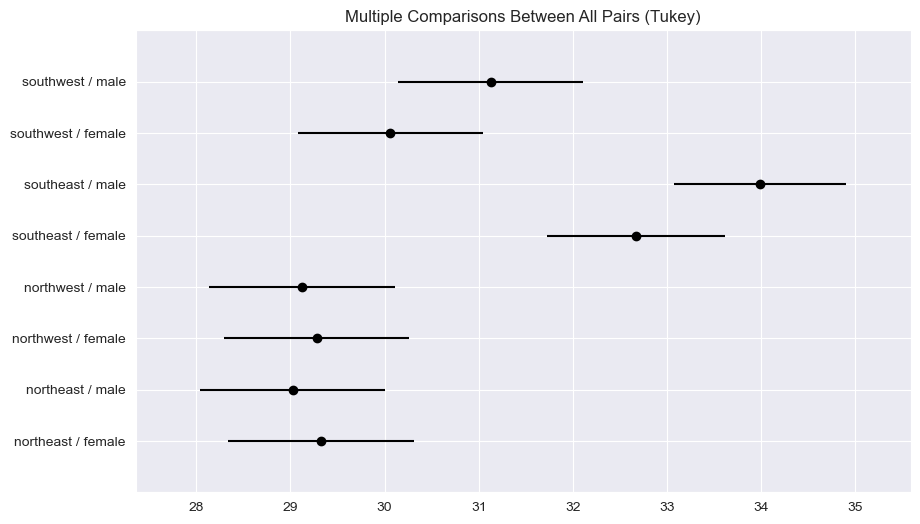

In [31]:
bmi['combination'] = bmi.region + ' / ' + bmi.sex
tukey = pairwise_tukeyhsd(endog=bmi['bmi'], groups=bmi['combination'], alpha=0.05)
tukey.plot_simultaneous()
tukey.summary()